# Gurobi

In [1]:
import gurobipy as gp
from gurobipy import GRB
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def generate_random_graph(n_nodes=8, p=0.5, seed=None):
    G = nx.erdos_renyi_graph(n_nodes, p, seed=seed)
    for (u, v) in G.edges():
        G.edges[u, v]['weight'] = np.random.randint(1, 10)
    return G

In [3]:
def maxcut_gurobi(G):
    n = G.number_of_nodes()
    m = gp.Model("maxcut")
    m.setParam('OutputFlag', 0)  # Silence output

    # Binary variables for each node
    x = m.addVars(n, vtype=GRB.BINARY, name="x")

    obj = gp.quicksum(
        G.edges[i, j]['weight'] * (x[i] + x[j] - 2 * x[i] * x[j])
        for i, j in G.edges()
    )
    m.setObjective(obj, GRB.MAXIMIZE)

    m.optimize()

    cut = [int(x[i].X) for i in range(n)]
    cut_value = m.objVal
    return cut, cut_value

In [4]:
def plot_cut(G, cut):
    pos = nx.spring_layout(G, seed=42)
    colors = ['red' if cut[i] else 'blue' for i in range(len(cut))]
    nx.draw(G, pos, with_labels=True, node_color=colors, node_size=500)
    labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
    plt.title("Max-Cut Partition")
    plt.show()

Set parameter Username
Set parameter LicenseID to value 2675834
Academic license - for non-commercial use only - expires 2026-06-06
Gurobi Max-Cut value: 67.0


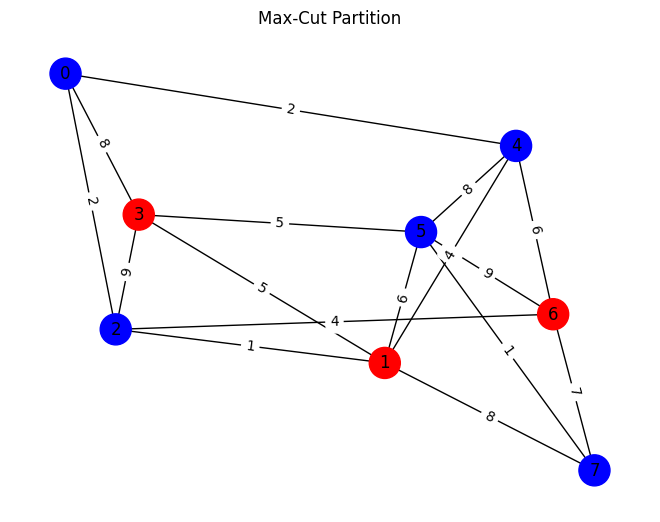

In [5]:
G = generate_random_graph(n_nodes=8, p=0.5, seed=42)
cut, value = maxcut_gurobi(G)
print(f"Gurobi Max-Cut value: {value}")

plot_cut(G, cut)